# Annexes techniques — contrôles et cohérence

Ce notebook complète l’analyse exploratoire présentée dans
`01_EDA_python.ipynb`.

Il contient l’ensemble des contrôles de qualité, des vérifications
méthodologiques et des recoupes techniques (CSV pédagogique vs
export BigQuery), non détaillés dans le notebook principal afin
d’en préserver la lisibilité.


### 1. Descriptions des variables

#### 1.1. Aperçu global du jeu de données et re-typage des données

In [9]:
import pandas as pd
import numpy as np

# Chargement du fichier csv
df = pd.read_csv("../data/thelook_fr_women_2023_2024.csv")

Une fois notre DataFrame créé, intéressons-nous aux colonnes grâce à la méthode .info de pandas, puis nous allons créer ensuite un dictionnaire les décrivant (définition, type, exemple).

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          1679 non-null   int64  
 1   order_item_id     1679 non-null   int64  
 2   product_id        1679 non-null   int64  
 3   item_created_at   1679 non-null   object 
 4   item_status       1679 non-null   object 
 5   sale_price        1679 non-null   float64
 6   cost              1679 non-null   float64
 7   category          1679 non-null   object 
 8   department        1679 non-null   object 
 9   brand             1677 non-null   object 
 10  product_name      1679 non-null   object 
 11  order_status      1679 non-null   object 
 12  order_created_at  1679 non-null   object 
 13  shipped_at        1133 non-null   object 
 14  delivered_at      636 non-null    object 
 15  user_id           1679 non-null   int64  
 16  gender            1679 non-null   object 


In [7]:
# Affichage des colonnes catégorielles
df.select_dtypes(include='object').head()

,item_created_at,item_status,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,gender,country,state,city
0,2023-01-01 06:18:03+00:00,Shipped,Shorts,Women,Fox,Fox Juniors Momentum Short,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,F,France,Centre-Val de Loire,Corquilleroy
1,2023-01-01 06:44:58+00:00,Shipped,Intimates,Women,Wacoal,Wacoal Women's B-Smooth Bralette,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,F,France,Centre-Val de Loire,Corquilleroy
2,2023-01-03 04:44:50+00:00,Complete,Intimates,Women,American Apparel,American Apparel Striped Chiffon Tank,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,F,France,Île-de-France,Paris
3,2023-01-03 15:13:39+00:00,Complete,Tops & Tees,Women,Tri-Mountain,Tri-Mountain Women's 3/4-Sleeve Pique Knit Pol...,Complete,2023-01-03 18:58:00+00:00,2023-01-05 13:23:00+00:00,2023-01-09 10:25:00+00:00,F,France,Hauts-de-France,Comines
4,2023-01-05 06:43:09+00:00,Complete,Pants & Capris,Women,Lauren by Ralph Lauren,Lauren Ralph Lauren Velour Pants,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,F,France,Île-de-France,Paris


Les date sont au format objet, ce qui n'est pas très pratique pour trier notre DataFrame.
Nous allons commencer par parser les dates.

In [11]:
# Colonnes de date 
col_dates = [
    "item_created_at", 
    "order_created_at", 
    "shipped_at", 
    "delivered_at"
]

# Formatage de la date 
for c in col_dates:
    dates = pd.to_datetime(df[c], errors='coerce')
    df[c] = dates

Puis les colonnes catégorielles en category :

In [12]:
for col in df.select_dtypes(include='object').columns.to_list():
    print(f'Colonne {col} : {df[col].nunique()}')

Colonne item_status : 5
Colonne category : 22
Colonne department : 1
Colonne brand : 657
Colonne product_name : 1559
Colonne order_status : 5
Colonne gender : 1
Colonne country : 1
Colonne state : 13
Colonne city : 547


In [13]:
# Changement des type object en category pour les variables catégorielles
cat_list = ["item_status", "category", "department", "order_status", "gender", "country", "state", "city"]
df[cat_list] = df[cat_list].astype('category')

Finalement après toutes ces opérations, il est temps de re-contrôler le type de nos données.

In [14]:
# Contrôle du type des données
df.dtypes

order_id                          int64
order_item_id                     int64
product_id                        int64
item_created_at     datetime64[ns, UTC]
item_status                    category
sale_price                      float64
cost                            float64
category                       category
department                     category
brand                            object
product_name                     object
order_status                   category
order_created_at    datetime64[ns, UTC]
shipped_at          datetime64[ns, UTC]
delivered_at        datetime64[ns, UTC]
user_id                           int64
gender                         category
country                        category
state                          category
city                           category
dtype: object

### 2. Contrôle de qualité des données

#### 2.1. Traitement des doublons

In [15]:
# Affichage des observations où on a pas d'information concernant la variable brand
df[df["brand"].isna()]

,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
320,40643,58980,755,2023-06-24 08:17:59+00:00,Returned,28.950001,15.14085,Tops & Tees,Women,NaN,The Very Hungry Caterpillar Classic Book Women...,Returned,2023-06-24 08:55:00+00:00,2023-06-24 20:32:00+00:00,2023-06-28 18:54:00+00:00,32624,F,France,Île-de-France,Paris
1237,25047,36362,13863,2024-08-12 09:56:12+00:00,Complete,24.250000,9.55450,Accessories,Women,NaN,Husky Animal Hat with Mittens,Complete,2024-08-12 13:30:00+00:00,2024-08-15 12:12:00+00:00,2024-08-18 05:02:00+00:00,20152,F,France,Île-de-France,Vélizy-Villacoublay


Une première stratégie d'imputation serait de chercher si ces produits se retrouvent ailleurs dans le DataFrame et leur imputer la valeur de brand d'un hypothétique même produit.

In [16]:
# Identification des product_id dont la marque est manquante
missing_brand_products = df.loc[df["brand"].isna(), "product_id"].unique()

# Vérification de s'ils apparaissent ailleurs dans le dataset
df[df["product_id"].isin(missing_brand_products)] \
  .sort_values("product_id")


,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
320,40643,58980,755,2023-06-24 08:17:59+00:00,Returned,28.950001,15.14085,Tops & Tees,Women,NaN,The Very Hungry Caterpillar Classic Book Women...,Returned,2023-06-24 08:55:00+00:00,2023-06-24 20:32:00+00:00,2023-06-28 18:54:00+00:00,32624,F,France,Île-de-France,Paris
1237,25047,36362,13863,2024-08-12 09:56:12+00:00,Complete,24.250000,9.55450,Accessories,Women,NaN,Husky Animal Hat with Mittens,Complete,2024-08-12 13:30:00+00:00,2024-08-15 12:12:00+00:00,2024-08-18 05:02:00+00:00,20152,F,France,Île-de-France,Vélizy-Villacoublay


Ces produits sont uniques, on ne peut donc pas imputer avec la valeur de brand hypothétique. On va donc se contenter de remplacer par *"missing"*.

In [17]:
# Imputation par missing
df.fillna({"brand": "missing"}, inplace=True)

# Affichage des observations où on a pas d'information concernant la variable brand
df[df["brand"]=="missing"]

,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
320,40643,58980,755,2023-06-24 08:17:59+00:00,Returned,28.950001,15.14085,Tops & Tees,Women,missing,The Very Hungry Caterpillar Classic Book Women...,Returned,2023-06-24 08:55:00+00:00,2023-06-24 20:32:00+00:00,2023-06-28 18:54:00+00:00,32624,F,France,Île-de-France,Paris
1237,25047,36362,13863,2024-08-12 09:56:12+00:00,Complete,24.250000,9.55450,Accessories,Women,missing,Husky Animal Hat with Mittens,Complete,2024-08-12 13:30:00+00:00,2024-08-15 12:12:00+00:00,2024-08-18 05:02:00+00:00,20152,F,France,Île-de-France,Vélizy-Villacoublay


#### 2.3. Cohérence des bornes temporelles


In [24]:
# Création des colonnes year et month
df["year"] = df["item_created_at"].dt.year
df["month"] = df["item_created_at"].dt.month

In [18]:
# Définition des bornes temporelles
date_limits = {
    "avant 2023": "2023-01-01 00:00:00+00:00",
    "après 2024": "2025-01-01 00:00:00+00:00"
}

# Affichage des bornes min / max
print(
    f"La date la plus ancienne de item_created_at est : {df['item_created_at'].min()}\n"
    f"La date la plus récente de item_created_at est : {df['item_created_at'].max()}\n"
)

# Comptage des dates hors périmètre
for label, limit in date_limits.items():
    count = (
        (df["item_created_at"] < limit).sum()
        if "avant" in label
        else (df["item_created_at"] > limit).sum()
    )
    print(f"Colonne item_created_at : {count} dates {label}")

La date la plus ancienne de item_created_at est : 2023-01-01 06:18:03+00:00
La date la plus récente de item_created_at est : 2024-12-31 10:40:48+00:00

Colonne item_created_at : 0 dates avant 2023
Colonne item_created_at : 0 dates après 2024


### 3. Explorations descriptives

#### 3.1. Distribution des données de prix de vente et de coût

In [19]:
# Contrôle Métier sur les colonnes prix de vente et coût
df[
    (df["sale_price"] <= 0) |
    (df["cost"] < 0) |
    (df["sale_price"] < df["cost"])
].shape[0]

0

**Répartition globale des statuts (toutes années confondues)**

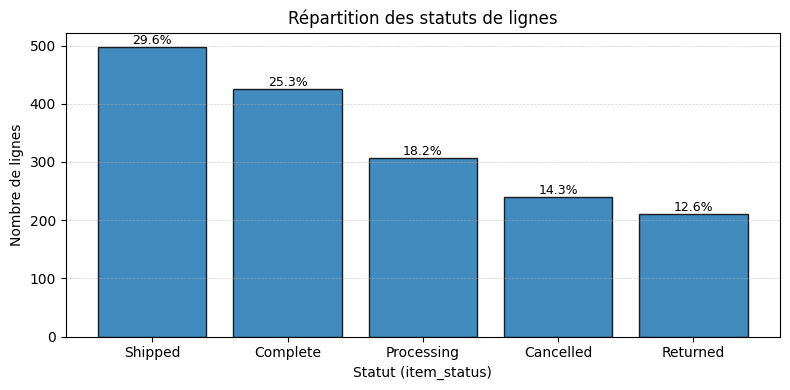

In [29]:
# Comptage des lignes par statut
counts = df["item_status"].value_counts()

# Calcul des parts relatives
pct = (counts / counts.sum() * 100).round(1)

# Construction du graphique
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(counts.index.astype(str), counts.values, edgecolor="black", alpha=0.85)

# Ajout des annotations (%)
for i, (c, p) in enumerate(zip(counts.values, pct.values)):
    ax.text(i, c, f"{p:.1f}%", ha="center", va="bottom", fontsize=9)

# Mise en forme et affichage
ax.set_title("Répartition des statuts de lignes")
ax.set_xlabel("Statut (item_status)")
ax.set_ylabel("Nombre de lignes")
ax.grid(True, axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

**Répartition des statuts par année**

In [25]:
# Répartition des statuts par année
status_year = (
    df.groupby(["year", "item_status"], observed=False)
      .size()
      .unstack(fill_value=0)
)

# Passage en pourcentage
status_year_pct = (
    status_year
    .div(status_year.sum(axis=1), axis=0)
    * 100
).round(1)

status_year_pct


item_status,Cancelled,Complete,Processing,Returned,Shipped
year,,,,,
2023,13.6,20.5,21.1,12.5,32.2
2024,14.8,28.8,16.1,12.6,27.7


La part des lignes au statut Complete progresse entre 2023 (20,5 %) et 2024 (28,8 %).

Cette évolution s’accompagne d’une diminution des statuts intermédiaires (Processing, Shipped), tandis que la part de lignes Returned reste stable.

Cette configuration suggère une amélioration du taux de finalisation des ventes plutôt plutôt qu’un effet de finalisation ou de temporalité des statuts.


Conclusion : la hausse du CA réalisé en 2024 est compatible avec une amélioration du taux de finalisation, et ne peut pas être attribuée uniquement à un changement de structure des statuts.

**Répartition mensuelle des lignes Complete**

In [26]:
# Répartition mensuelle des statuts
status_year_month = (
    df.groupby(["year", "month", "item_status"], observed=False)
      .size()
      .unstack(fill_value=0)
)

# Part mensuelle de Complete
status_year_month_pct = (
    status_year_month
    .div(status_year_month.sum(axis=1), axis=0)
    * 100
).round(1)

# On se concentre sur la part de Complete
status_year_month_pct["Complete"].unstack(level=0)


year,2023,2024
month,,
1,24.0,27.9
2,19.1,18.1
3,15.4,41.8
4,21.2,40.0
5,22.4,25.0
6,24.1,30.4
7,22.7,26.1
8,21.4,24.1
9,8.8,31.9


L’analyse mensuelle de la part de lignes Complete ne met pas en évidence de biais temporel en fin de période. Au contraire, les mois récents de 2024 présentent des taux de finalisation élevés, supérieurs à ceux observés en 2023 sur les mêmes mois.

En particulier, la fin d’année 2024 présente des parts Complete élevées, ce qui ne va pas dans le sens d’un effet de commandes “pas encore finalisées”.

**Cohérence order_status vs item_status**

In [27]:
# Table de contingence order_status vs item_status
pd.crosstab(df["order_status"], df["item_status"])


item_status,Cancelled,Complete,Processing,Returned,Shipped
order_status,,,,,
Cancelled,240,0,0,0,0
Complete,0,425,0,0,0
Processing,0,0,306,0,0
Returned,0,0,0,211,0
Shipped,0,0,0,0,497


La table de contingence entre order_status et item_status montre une correspondance parfaite entre les deux niveaux. Chaque commande présente un statut homogène sur l’ensemble de ses lignes, ce qui garantit l’absence d’incohérence entre analyses au grain ligne et au grain commande.

### 4. Comparaison 2023 vs 2024